In [37]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [38]:
base_dir = 'images'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir, 'test')

In [39]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                   # Normaliza imágenes
    rotation_range=30,                # Rota ligeramente para variar perspectiva
    width_shift_range=0.15,           # Desplaza horizontalmente
    height_shift_range=0.15,          # Desplaza verticalmente
    shear_range=0.1,                  # Corta levemente para simular deformaciones
    zoom_range=[0.9, 1.1],            # Simula zoom in/out
    horizontal_flip=True,             # Refleja horizontalmente
    brightness_range=[0.8, 1.2],      # Simula distintas condiciones de luz
    fill_mode='nearest'               # Relleno de pixeles vacío
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [41]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    shuffle=True,
    color_mode='rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)

Found 508 images belonging to 2 classes.
Found 61 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


<Figure size 640x480 with 0 Axes>

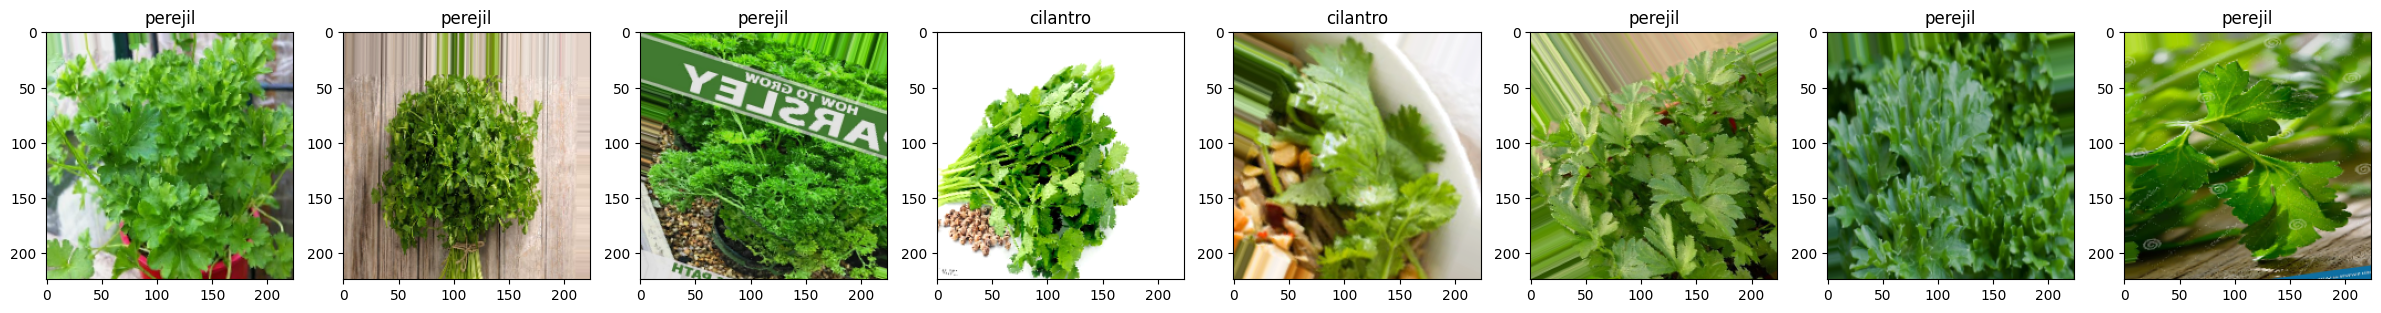

In [42]:
# Visualizar imágenes despúes de escalamiento y preprocesado
images, labels = train_generator[0]

class_names = list(train_generator.class_indices.keys()) # Obtener nombres de clases
label_indices = labels.astype(int)

plt.figure()
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4))

for i in range(images.shape[0]):
    axarr[i].imshow(images[i].squeeze()) 
    axarr[i].set_title(class_names[label_indices[i]], fontsize=12)

### MobileNetV2

In [49]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# === 1. CARGA Y PREPROCESAMIENTO DE DATOS ===
base_dir = 'images'
target_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(os.path.join(base_dir, 'train'), target_size=target_size, batch_size=32, class_mode='binary')
val = test_datagen.flow_from_directory(os.path.join(base_dir, 'validation'), target_size=target_size, batch_size=32, class_mode='binary')
test = test_datagen.flow_from_directory(os.path.join(base_dir, 'test'), target_size=target_size, batch_size=32, class_mode='binary', shuffle=False)

# === 2. MODELO CON EfficientNetB0 ===
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# === 3. ENTRENAMIENTO ===
history = model.fit(train, epochs=25, validation_data=val)

# === 4. MATRIZ DE CONFUSIÓN Y REPORTE ===
y_true = test.classes
y_pred_probs = model.predict(test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

labels = list(test.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.show()

print("📊 Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=labels))

# === 5. GRAD-CAM PARA ERRORES ===
def grad_cam(model, image, last_conv_layer_name='efficientnetb0/top_activation'):
    # Extrae el submodelo EfficientNetB0
    base_model = model.get_layer('efficientnetb0')
    last_conv_layer = base_model.get_layer(last_conv_layer_name.split('/')[-1])

    # Crea el modelo intermedio correctamente conectado
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(tf.expand_dims(image, axis=0))
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap + 1e-8)
    return heatmap.numpy()


# Mostrar 5 errores y dónde miró el modelo
test.reset()
errors_shown = 0
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        image = test[i // test.batch_size][0][i % test.batch_size]
        heatmap = grad_cam(model, image)
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.title(f"❌ Error: predijo={labels[y_pred[i]]}, real={labels[y_true[i]]}")
        plt.axis('off')
        plt.show()
        errors_shown += 1
        if errors_shown >= 5:
            break


Found 508 images belonging to 2 classes.
Found 61 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


Epoch 1/25
16/16 [==============================] - 12s 575ms/step - loss: 0.6946 - accuracy: 0.5571 - val_loss: 0.7045 - val_accuracy: 0.5246
Epoch 2/25
16/16 [==============================] - 32s 2s/step - loss: 0.7062 - accuracy: 0.4980 - val_loss: 0.7108 - val_accuracy: 0.5082
Epoch 3/25
16/16 [==============================] - 41s 2s/step - loss: 0.6923 - accuracy: 0.5295 - val_loss: 0.7001 - val_accuracy: 0.5410
Epoch 4/25
16/16 [==============================] - 40s 3s/step - loss: 0.7060 - accuracy: 0.4980 - val_loss: 0.7140 - val_accuracy: 0.3934
Epoch 5/25
16/16 [==============================] - 31s 2s/step - loss: 0.7036 - accuracy: 0.5197 - val_loss: 0.6927 - val_accuracy: 0.5902
Epoch 6/25
16/16 [==============================] - 34s 2s/step - loss: 0.7128 - accuracy: 0.4941 - val_loss: 0.7138 - val_accuracy: 0.4590
Epoch 7/25
16/16 [==============================] - 34s 2s/step - loss: 0.6942 - accuracy: 0.5138 - val_loss: 0.6950 - val_accuracy: 0.5410
Epoch 8/25
16/16 

KeyboardInterrupt: 

2/2 [==============================] - 1s 308ms/step - loss: 0.7079 - accuracy: 0.4516


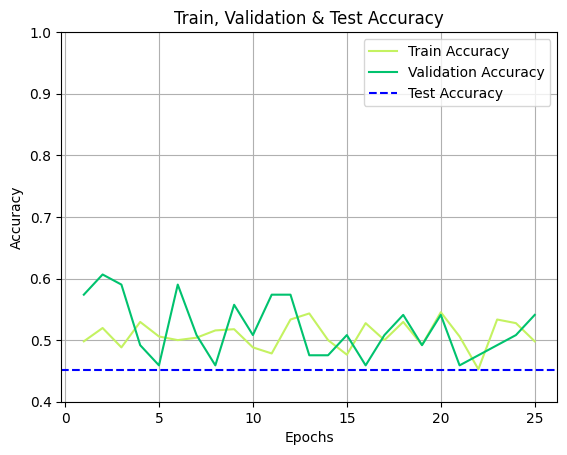

2/2 [==============================] - 1s 324ms/step - loss: 0.7082 - accuracy: 0.4839


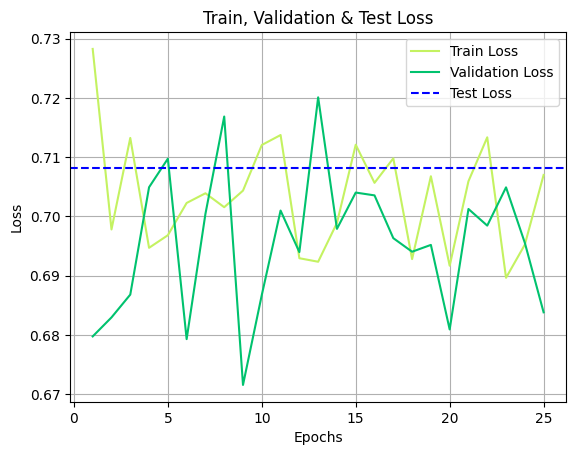

In [48]:
# === Evaluación en test ===
test_loss, test_acc = model.evaluate(test)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# === Accuracy Plot ===
plt.figure()
plt.plot(epochs, accuracy, color='#C4F261', label='Train Accuracy')
plt.plot(epochs, val_accuracy, color='#00C26E', label='Validation Accuracy')
plt.axhline(y=test_acc, color='blue', linestyle='--', label='Test Accuracy')
plt.title('Train, Validation & Test Accuracy')
plt.ylim(0.4, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# === Loss Plot ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']
test_loss = model.evaluate(test)[0]

plt.figure()
plt.plot(epochs, train_loss, color='#C4F261', label='Train Loss')  
plt.plot(epochs, val_loss, color='#00C26E', label='Validation Loss')     
plt.axhline(y=test_loss, color='blue', linestyle='--', label='Test Loss')
plt.title('Train, Validation & Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### CNN Propia

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras import optimizers


def get_model_deep(input_shape, num_classes=2):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
num_classes = train_generator.num_classes

model = get_model_deep((150, 150, 1), num_classes=num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 32)                1

In [ ]:
def train_model_deep(model, train_generator, validation_generator):
    history = model.fit(train_generator, epochs=50, validation_data=validation_generator)
    return history
    
history = train_model_deep(model, train_generator, validation_generator)

### Evaluación de Modelo

In [25]:
from sklearn.metrics import classification_report

# Obtener predicciones
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Etiquetas verdaderas
y_true = test_generator.classes

# Nombres de clases
class_labels = list(test_generator.class_indices.keys())

# Reporte de métricas
print("Reporte:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

2/2 [==============================] - 1s 267ms/step
Reporte:

              precision    recall  f1-score   support

    cilantro       0.50      1.00      0.67        31
     perejil       0.00      0.00      0.00        31

    accuracy                           0.50        62
   macro avg       0.25      0.50      0.33        62
weighted avg       0.25      0.50      0.33        62



/Users/fridabg/Desktop/Cilantro-Perejil/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fridabg/Desktop/Cilantro-Perejil/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fridabg/Desktop/Cilantro-Perejil/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

2/2 [==============================] - 1s 273ms/step - loss: 1.0311 - accuracy: 0.5161


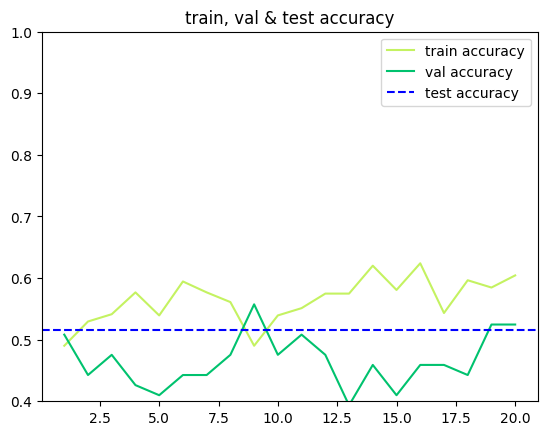

2/2 [==============================] - 1s 255ms/step - loss: 1.0311 - accuracy: 0.5161


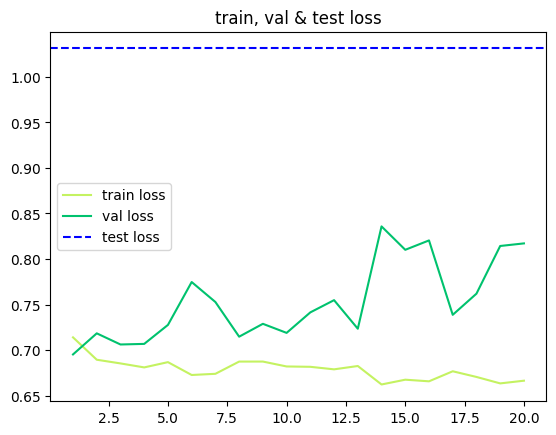

In [26]:
# Accuracy
test_loss, test_acc = model.evaluate(test_generator)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure()
plt.plot(epochs, accuracy, color='#C4F261', label='train accuracy')
plt.plot(epochs, val_accuracy, color='#00C26E', label='val accuracy')
plt.axhline(y=test_acc, color='blue', linestyle='--', label='test accuracy')
plt.title('train, val & test accuracy')
plt.ylim(0.4, 1)
plt.legend()
plt.show()

# Loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

results = model.evaluate(test_generator)
test_loss = results[0]  

plt.figure()
plt.plot(epochs, train_loss, color='#C4F261', label='train loss')  
plt.plot(epochs, val_loss, color='#00C26E', label='val loss')     
plt.axhline(y=test_loss, color='blue', linestyle='--', label='test loss')

plt.title('train, val & test loss')
plt.legend()
plt.show()

2/2 [==============================] - 1s 251ms/step


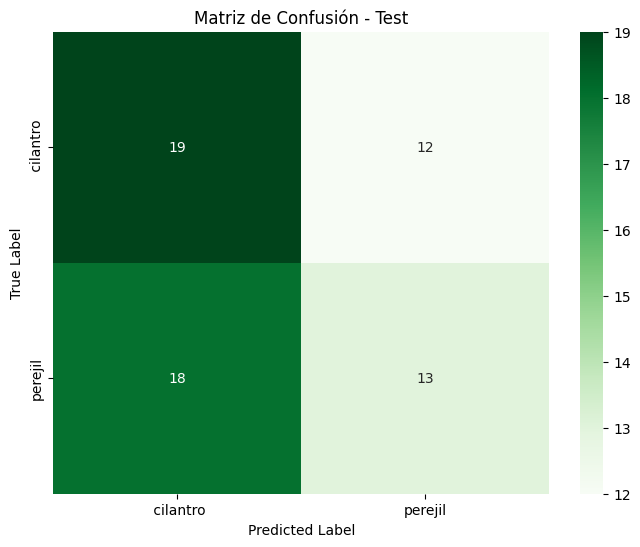

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Obtener predicciones del modelo
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
# Obtener etiquetas verdaderas del generador
y_true = test_generator.classes

# Nombres de las clases
class_labels = list(test_generator.class_indices.keys())

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matriz de Confusión - Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()